# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Background estimation 


#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats     as stats  # statistics and Many PDFs 
#import scipy.optimize  as optimize # Minimice funtions

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
import importlib
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective

**Estimate the background contamination**, the number of Bi and Tl events, using blind-data.

### Tasks


   * Open the data file (HDF) and access the mock calibration blind-data.
   
   * Estimate the number of Bi, Tl events in your blind-data.
   
     * Fit the energy distribution to a combination of energy distributions of Bi and Tl obtained from MC.
              
   * Test that the data-blind distributions are as expected according to MC. 
   
   * Estimate the background index in your RoI

## Notes


A **blind analysis** is an analysis in which the data in a region of interest is blind or masked during the analysis. 

The analysis must be first completely defined, the procedures and methods verified, before analyzing the complete data set. 

A blind-analysis tries to avoid a human bias.


## Notes


In this exercise we need to estimate the number of background events in a blind-data set.

Blind data are those events in which the main track, track0_E, has an energy or the blob2 Energy, blob2_E, are in the signal region, are removed from data

In order to estimate the number of bkg events in the data, we use here the total energy of the event. 

We fit the energy distribution of the blind data to a composite sample, which is a weighted distribution of the energy distributions obtained with the MC samples, from which we previously removed events in the blind region.


### An etended likelihood fit

We generate the pdf of a variable (energy) for each mc sample, and define later a combined PDF, $f(x | {\bf n})$ with parameters are ${\bf n} = (n_{bb}, n_{Bi}, n_{Tl})$ the number of events in each sample. 

$$
f(x | {\bf n}) = \sum_i \frac{n_i}{n} \, f_i(x)
$$

where $i$ is the index of each sample, $(\beta\beta0\nu,\, \mathrm{Bi}, \, \mathrm{Tl})$;  $f_i(x)$ the pdf of sample $i$ and $n = \sum_i n_i$

We then compute the likelihood of our sample, $\mathcal{L}({\bf x} | {\bf n}) = \Pi_{i=1}^m f(x_i | {\bf n})$ 
and minimize $- 2 \log \mathcal{L}({\bf x} | {\bf n})$.



An Extended Likelihood includes also the factor of the probability of observing $m$ events expecting $n$.

The total likelihood is:

$$
\mathcal{L}_{ext}({\bf x} | {\bf n}) = g(m | n) \; \Pi_{i=1}^m f(x_i | {\bf n})
$$

where $g(m|n)$ is the poisson PDF with mean $n$.



## Recomendations

Generate the MC PDFs for the different samples and construct the combined PDF. 

You can create a PDF from a histogram (see [scipy stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_histogram.html)). 

Validate your fit with random experiments.

In this guide there is an example of an Extended Maximum Likelihood method.




## Main Parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


## Access the data

In [6]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = '/data/fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
#mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')
datab = pd.read_hdf(dirpath + filename, key = 'data/blind')

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


### Utilities

In [7]:
samples  = ['Bi', 'Tl']
ssamples = [r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbi, mctl]

## Inspect the variables

In [8]:
#pltext.df_inspect(datab, ncolumns = 3)

## Energy distribution of the blind-data

Plot the energy distribution of the blind-data

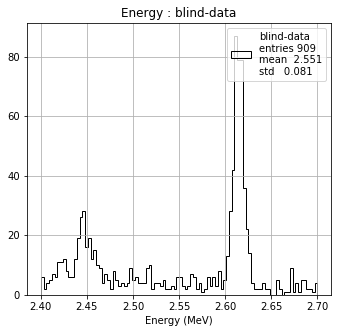

In [9]:
def plt_energy(df, label = '', bins = 100, erange = erange):

    subplot = pltext.canvas(1)
    subplot(1)
    pltext.hist(df.E, bins, range = erange, label = label)
    plt.xlabel('Energy (MeV)'); 
    plt.title('Energy : ' + label)
    
plt_energy(datab, 'blind-data')

## Estimate the number of background events in the blind-data

  1) Remove from the MC the events in the blind region. 

  2) Obtain the PDFs distribution for a reference variable, i.e. energy, for each sample; 

  3) Generate a combined PDF where the parameters are the number of events of each sample.

  4) Fit the distribution of that variable to a combined PDF and to estimate the number of background events, Bi, Tl.

  5) Compute the total number of background events in the sample and the events in the RoI.

### Generate MC-blind samples

Generate MC sample without events in the blind region.

The function *selection_blind(mc)* returns the selection with the blind events

Plot the energy

In [10]:
sels_blind = [fn.selection_blind(mc) for mc in mcs]
mcs_blind  = [mc[sel] for mc, sel in zip(mcs, sels_blind)]
for i, mc in enumerate(mcs):
    print('number of events {:s}: total {:d} in blind data {:d}'.format(samples[i], len(mcs[i]), len(mcs_blind[i])))

number of events Bi: total 60184 in blind data 53758
number of events Tl: total 687297 in blind data 674815


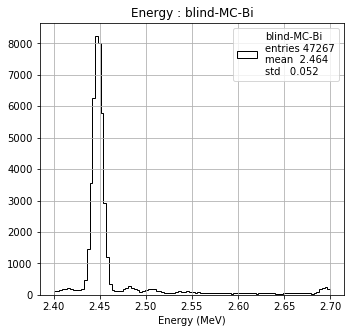

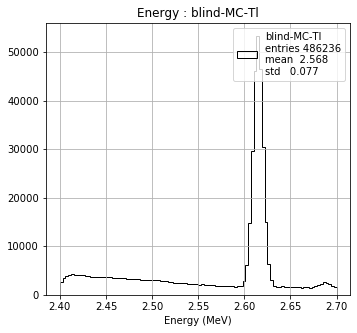

In [11]:
for i, mc in enumerate(mcs):
    plt_energy(mcs_blind[i], 'blind-MC-'+samples[i])

### An example of how to generate PDFs from histograms

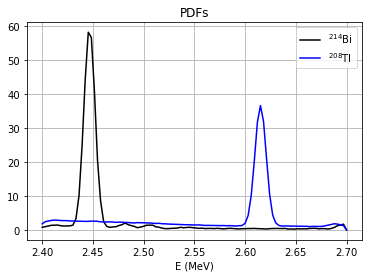

In [12]:
bins = 100
# generate the PDFs of the mcsblind DFs making histograms
pdfs = []
varname  = 'E' 
varrange = erange
for mc in mcs_blind:
    histo = np.histogram(mc[varname], bins, range = varrange);
    pdf = stats.rv_histogram( histo )
    pdfs.append(pdf)

xs   = np.linspace(*varrange, bins)
for i, pdf in enumerate(pdfs): 
    plt.plot(xs, pdf.pdf(xs), label = ssamples[i])
plt.grid(); plt.legend(); 
plt.xlabel('E (MeV)'); plt.title('PDFs');

### An example: generate a random experiment using combined pdfs and do a fit

Construct an 'Extended Combined PDF' object (see class ExtComPDF in module efit.py). 

This object can generate random events (*rvs* method), provides the PDF (*pdf* method), the extended log likelihood (*loglike*) and even the fit to a best estimate (*best_estimate*).

Internally it uses the module *optimize* of *scipy* ([see](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)). 

Here an example with our previously construced PDFs of each sample.

True parameters     : 1000.00, 2000.00
Fit success? True,
Estimated parameters: 980.89, 2052.56


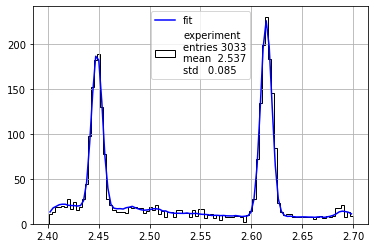

In [13]:
## generate the combined PDF 
nns  = (1000, 2000) # number of events of each sample
print('True parameters     : {:6.2f}, {:6.2f}'.format(*nns))
ell = efit.ExtComPDF(pdfs, *nns)

# generate a random experiment
xs  = ell.rvs()
# plot the random events
_, edges, _ = pltext.hist(xs, 100, label = 'experiment');

# fit using the Extended Log Likelihood
res = ell.best_estimate(xs, *nns)
# access the information of the 'res' Result Object (see )
print('Fit success? {:s},\nEstimated parameters: {:6.2f}, {:6.2f}'.format(str(res.success), *res.x))

# overplot the fit result
ns_est  = res.x
centers = 0.5 * (edges[1:] + edges[:-1])
scale   = np.sum(ns_est) * (edges[1] - edges[0])
pdf     = ell.pdf # access to the pdf function inside the composite-PDF object
plt.plot(centers, scale * pdf(centers, *ns_est), label = 'fit')
plt.legend();

## Fit blind-data using an Extended Likelihood Fit

Now we fit the blind-data to an Entended Likelihood fit.

The code is in the module *fanal* in the function *fit_ell*.

Number of events : 117.14,  791.88, 


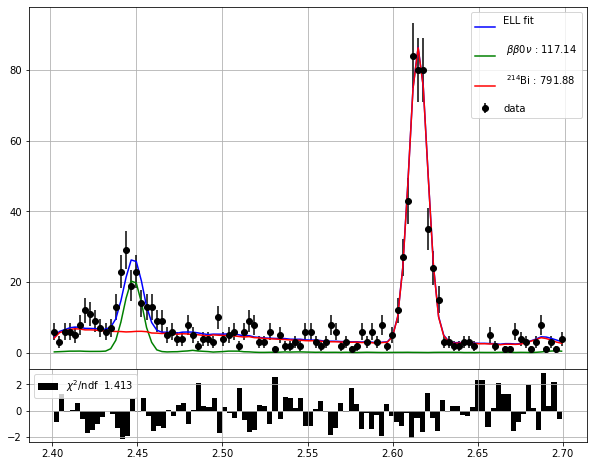

In [14]:
ns       = (2200., 5200.) # initial guess of the number of events in the blind sample
bins     = 100
varname  = 'E'
varrange = erange
# fit_ell: internally generates the composite pdf, calls the fit and returns the fit-result
result, ene, ell, pdfs = fn.fit_ell(datab, mcs_blind, ns, varname = varname, varrange = varrange, bins = bins)
ns_est = result.x
print('Number of events :', *['{:6.2f}, '.format(ni) for ni in ns_est])
# it also plots the histogram, the fit function, and the pdfs samples
fn.plot_fit_ell(ene, ns_est, ell.pdf, pdfs)

*TODO*: Compute the parameters uncertainties

## Compute the total number of background events

In [15]:
effs_erange = [] 
effs_total  = []
for mc in [mcbi, mctl]:
    # efficiency of the selection of E in the erange
    eeff, _ = ut.efficiency(ut.selection(mc, 'E', erange))
    # efficiency of the blind selection
    beff, _ = ut.efficiency(fn.selection_blind(mc))
    # total effiency for the events in the Fit
    eff = eeff * beff
    effs_erange.append(eeff)
    effs_total .append(eff)

print(' E range   efficiency : ', *['{:s} = {:6.4f}'.format(s, eff) for s, eff in zip(samples, effs_erange)])
print(' E & blind efficiency : ', *['{:s} = {:6.4f}'.format(s, eff) for s, eff in zip(samples, effs_total)])
    
nevents = [ni / eff for ni, eff in zip(ns_est, effs_total)]
print(' Total Bkg Events     : ', *['{:s} = {:6.2f}'.format(s, ni) for s, ni in zip(samples, nevents)])

 E range   efficiency :  Bi = 0.8874 Tl = 0.7225
 E & blind efficiency :  Bi = 0.7927 Tl = 0.7094
 Total Bkg Events     :  Bi = 147.77 Tl = 1116.29


### Calculate the background index in the RoI 

The background index in the number of events expected in the RoI region per keV and exposure (kg y). 

The units os bkg-index are: *counts/ (keV kg y)*

This number is an indication of how good an experiment is. It helps to compare different experiments. 

The *exposure* if the *kg y* of data collected by an experiment. 

For example a 100 kg detector operating 5 years, has an exposure of 500 kg y.

For a given exposure, it cuantifies what experiments is the best.

In the energy region of interest (RoI), *eroi* MeV, where most of the bb0nu data are.

In [16]:
selnames  = ['E', 'num_tracks', 'blob2_E', 'E']
selranges = [erange, (1., 1.1), (eblob2, np.inf), eroi]

effs      = [fn.efficiencies(mc, selnames, selranges) for mc in mcs] # efficiencies after each cut
effs_roi  = [eff[0][-1] for eff in effs]                             # total efficiency of the selection
nrois     = [nevt * eff for nevt, eff in zip(nevents, effs_roi)]     # Expected numbers of events in RoI

for i, eff in enumerate(effs_roi):
    print('Sample {:s}: total efficiency = {:1.2e}, events in RoI = {:6.2f}'.format(samples[i], eff, nrois[i]))

Sample Bi: total efficiency = 1.55e-02, events in RoI =   2.29
Sample Tl: total efficiency = 1.94e-04, events in RoI =   0.22


Every collaboration has a different exposure! Ask for it!

In [17]:
exposures  = {'test_alpha': 500, 'test_beta': 1000, 'test_gamma': 1000,
              'test_delta': 3000, 'test_epsilon': 3000}
exposure   = exposures[coll]
roi_size   = 1e3 * (eroi[1] - eroi[0]) # keV
bkg_index  = np.sum(nrois)/(roi_size * exposure) # counts/ (keV kg y)

print('RoI               : ', eroi, ' MeV.')
print('RoI size          : {:6.3} keV.'.format(roi_size))
print('Bkg events in RoI : ', *['{:s} \t {:6.2f},'.format(s, ni) for s, ni in zip(samples, nrois)])
print('Exposure          : ', exposure, ' kg y.')
print('Bkg index in RoI  : {:1.2e} counts/(kg keV y).'.format(bkg_index))

RoI               :  (2.43, 2.48)  MeV.
RoI size          :   50.0 keV.
Bkg events in RoI :  Bi 	   2.29, Tl 	   0.22,
Exposure          :  500  kg y.
Bkg index in RoI  : 1.00e-04 counts/(kg keV y).


## Write out

In [18]:
write = True
if (write):
    of = open('collpars.py', 'a')
    of.write('exposure         = {:6.2f}'.format(exposure)+' # kg y \n')
    of.write('bkg_index        = {:1.3e}'.format(bkg_index)+' # counts /(keV kg y) \n')
    of.write('roi_size         = {:6.3f}'.format(roi_size)+' # keV \n') 
    for i, sample in enumerate(samples):
        of.write('eff_'+sample+'_blind     = {:6.3f}'.format(effs_total[i])+'\n')
        of.write('nevts_'+sample+'_blind   = {:6.3f}'.format(ns_est[i])+'\n')
        of.write('nevts_'+sample+'         = {:6.3f}'.format(nevents[i])+'\n')
        of.write('nevts_'+sample+'_RoI     = {:6.3f}'.format(nrois[i])+'\n')
    of.close()